# Practice Session 03: Networks from text

*Introduction to Network Science* (2025/26), UPF

In this session we will learn to construct a network from a set of implicit relationships. The relationships that we will study are between accounts on Twitter (currently X), a micro-blogging service.

We will create two networks: one directed and one undirected.

* In the **directed mention network**, we will say that there is a link of weight *w* from account *x* to account *y*, if account *x* has re-tweeted (re-posted) or mentioned *w* times account *y*.

* In the **undirected co-mention network**, we will say that there is a link of weight *w* between accounts *x* and *y*, if both accounts have been mentioned together in *w* tweets.

The input material you will use is a file named `CovidLockdownCatalonia.json.gz` available in the [`data/`](data/) directory. This is a gzip-compressed file, which you can de-compress using the `gunzip` command. The file contains around 35,500 messages ("tweets") posted between March 13th, 2020, and March 14th, 2020, containing a hashtag or keyword related to COVID-19, and posted by a user declaring a location in Catalonia.

The tweets are in a format known as [JSON](https://en.wikipedia.org/wiki/JSON#Example). That means every line in the file (corresponding to one tweet) represents a valid JSON object. Python's `json` library takes care of translating it into a dictionary.

**How was this file obtained?** This file was obtained from [CrisisNLP](https://crisisnlp.qcri.org/covid19). This is a website that provides COVID-19 collections of tweets, however, they only provide the identifier of the tweet, known as a tweet-id. To recover the entire tweet, a process commonly known as *re-hydration* was used, which involves querying an API from Twitter, giving the tweet-id, and obtaining the tweet. This can be done with a little bit of programming or using a software such as [twarc](https://github.com/DocNow/twarc#dehydrate).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Your name here</font>

E-mail: <font color="blue">Your e-mail here</font>

Date: <font color="blue">The current date here</font>

# 1. Create the directed mention network

Create the **directed mention network**, which has a weighted edge (source, target, weight) if user *source* mentioned user *target* at least once; with *weight* indicating the number of mentions.

Create two files: one containing all edges, and one containing all edges having *weight* greater or equal than 3.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [2]:
import io
import json
import gzip
import csv
import re

In [3]:
# Input file
COMPRESSED_INPUT_FILENAME = "data/CovidLockdownCatalonia.json.gz"   # You may need to change this filepath depending on where you've saved the data file

# These are the output files, leave as-is
OUTPUT_ALL_EDGES_FILENAME = "CovidLockdownCatalonia.csv"
OUTPUT_FILTERED_EDGES_FILENAME = "CovidLockdownCatalonia-min-weight-filtered.csv"
OUTPUT_CO_MENTIONS_FILENAME = "CovidLockdownCatalonia-co-mentions.csv"

## 1.1. Extract mentions

The `extract_mentions(text)` functions is used to extract user mentions (in format '@username') from text. For instance, if we give it the string `"RT @elnacionalcat: check this post by @en_blau"`, it returns the list `['elnacionalcat', 'en_blau']`.

You can now print all the people mentioned in a tweet by doing:

```python
mentions = extract_mentions(message)
for mention in mentions:
    print(f"{author} mentioned {mention}")
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [4]:
# Leave this code as-is

def extract_mentions(text):
    return re.findall("@([a-zA-Z0-9_]{5,20})", text)

print(extract_mentions("RT @elnacionalcat: check this post by @en_blau"))

['elnacionalcat', 'en_blau']


## 1.2. Count mentions


We do not need to uncompress the input file (it is about 236 MB uncompressed, but only 31 MB compressed), instead we can read it directly while it is compressed using the `gzip` library.

For example, to read a file line by line, converting each line to a dictionary with the `json` package, we can do something like: 

```python
with gzip.open(FILENAME, "rt", encoding="utf-8") as input_file:
    for line in input_file:
        tweet = json.loads(line)
        print(tweet)
```

The above code simply prints each line (tweet). Your task is to count the number of times mentions happen, for which you should create and populate a dictionary:

```python
mentions_counter = {}
```

Each key in the dictionary will be a tuple `(author, mention)` where `author` is the username of the person who writes the tweet, and `mention` the username of the person mentioned in the tweet. To update the dictionary, read the input file `COMPRESSED_INPUT_FILENAME` line by line and update the key-value pairs in `mentions_counter` for each mention in each tweet.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>


<font size="+1" color="red">Replace this cell with your code to read the compressed input file and create the `mentions_counter` dictionary.</font>

In [5]:
with gzip.open(COMPRESSED_INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    mentions_counter = {}
    for line in input_file:
        tweet = json.loads(line)
        author = tweet["user"]["screen_name"]
        text = tweet["full_text"]
        mentions = extract_mentions(text)
        for mention in mentions:
            key = (author, mention)
            mentions_counter[key] = mentions_counter.get(key, 0) + 1
            

        

Print the number of times the account `joanmariapique` mentioned `catalangov`. It should be 9.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [6]:
print(mentions_counter[('joanmariapique', 'catalangov')])

9



<font size="+1" color="red">Replace this cell with your code to print all the pairs of accounts (u,v) in which account *u* mentioned account *v*, and account *v* mentioned account *u* more than 8 times in total. Do not repeat pairs, i.e., if you print "Accounts @a and @b mention each other ..." do not additionally print "Accounts @b and @a mention each other ..." only print the sum of the @a and @b co-mentions ("Accounts @a and @b mention each other N times")</font>


In [7]:
seen_pairs = set()

for (u,v), count in mentions_counter.items():
    pair = tuple(sorted((u, v)))
    total = count + mentions_counter.get((v, u), 0)
    if total > 8 and pair not in seen_pairs:
        seen_pairs.add(pair)
        print(f"Accounts @{pair[0]} and @{pair[1]} mention each other {total} times")

Accounts @updayESP and @wualaswold1 mention each other 9 times
Accounts @DrTedros and @emocionycambio mention each other 16 times
Accounts @FXstreetNews and @HareshMenghani mention each other 11 times
Accounts @MargaXrepublica and @MargaXrepublica mention each other 12 times
Accounts @DrEricDing and @Txesnut1 mention each other 11 times
Accounts @catalangov and @joanmariapique mention each other 9 times


## 1.3 Save network

Write a file `OUTPUT_ALL_EDGES_FILENAME` with ***all*** the edges in this graph `(Source, Target, Weight)` as a tab-separated file, and `OUTPUT_FILTERED_EDGES_FILENAME` with edges of weight larger or equal to 3.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [8]:
# Leave this code as-is

lines_written = 0

with io.open(OUTPUT_ALL_EDGES_FILENAME, "w") as output_file:
    writer = csv.writer(output_file, delimiter='\t', quotechar='"')
    writer.writerow(["Source", "Target", "Weight"])
    for key in mentions_counter:
        author = key[0]
        mention = key[1]
        weight = mentions_counter[key]
        writer.writerow([author, mention, weight])
        lines_written += 1

print(f"Wrote {lines_written} lines to file {OUTPUT_ALL_EDGES_FILENAME}")

Wrote 34040 lines to file CovidLockdownCatalonia.csv


<font size="+1" color="red">Replace this cell with your code to create a file named `OUTPUT_FILTERED_EDGES_FILENAME` containing all (author, mention) pairs with a value greater or equal to 3.</font>

In [11]:
lines_written = 0

with io.open(OUTPUT_FILTERED_EDGES_FILENAME, "w", encoding="utf-8") as output_file:
    writer = csv.writer(output_file, delimiter="\t", quotechar='"')
    writer.writerow(["Source", "Target", "Weight"])
    for (author, mention), weight in mentions_counter.items():
        if weight >= 3:
            writer.writerow([author, mention, weight])
            lines_written += 1

print(f"Wrote {lines_written} lines to file {OUTPUT_FILTERED_EDGES_FILENAME}")


Wrote 255 lines to file CovidLockdownCatalonia-min-weight-filtered.csv


# 2. Visualize the directed mention network


The goal in this section is to extract the largest connected component of the network we just generated, visualize it, and do some basic analysis on it.

You have done this with Cytoscape in previous practices, but now we will do it with the [NetworkX](https://networkx.org/) Python package. This is the *de facto* standard tool for network analysis in Python, and it will be a very useful addition to your data analysis and modelling toolbox.

Since from now on we will analyze networks programmatically with `networkx`, you will find it necessary and useful to consult the **[NetworkX documentation](https://networkx.org/documentation/stable/index.html)**, especially the [Refernce](https://networkx.org/documentation/stable/reference/index.html) and [Gallery](https://networkx.org/documentation/stable/auto_examples/index.html).

(If you wish, you may follow or skim through the [Tutorial](https://networkx.org/documentation/stable/tutorial.html) to get an overview of the syntax and functionality of `networkx`.)

---

:warning: **Why NetworkX?** There are many tool for network visualization and analysis. Software applications like [Cytoscape](https://cytoscape.org/) and [Gephi](https://gephi.org/) allow for performing basic analysis in a fast, no-coding way, and provide many conveniences for visualization, but they usually have a fixed functionality and are difficult to extend. On the other end of the spectrum, software packages like [graph-tool](https://graph-tool.skewed.de/), [igraph](https://igraph.org/), and [graphviz](https://graphviz.org/#download) provide efficient algorithms for analysis and visualization of large networks, but may be less intuitive and take more time to learn and get used to. [NetworkX](https://networkx.org/) has become popular partly because it sits somewhere in the middle: with easy installation, fairly intuitive API, and decent flexibility. You might not need it for the most basic analysis, and if you have very large networks it might be too slow, but for a vast range of applications it's a versatile, powerful tool for network analysis, and thus you will find it useful as a data science tool going forward.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

First, create a network from the filtered edges by reading the file created in the previous section. 

NetworkX basically involves creating and manipulating different [`Graph` classes](https://networkx.org/documentation/stable/reference/classes/index.html) that hold [nodes](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.nodes.html), [edges](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edges.html), and node/edge [attributes](https://networkx.org/documentation/stable/reference/functions.html#attributes).

For each line in the file that corresponds to an edge, add that source-target edge (preserving the direction of mentions) with its respective weight (number of mentions) to a network `g`. Since our network of mentions is directed, make sure to use the `nx.DiGraph()` class (stands for "**Di**rected **Graph**").

*Tip: You can use either the `csv.reader()` or `csv.DictReader()` function. They differ in the kind of Python objects they parse entries into, both can be useful!*

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [9]:
# Import required packages

import networkx as nx
import matplotlib.pyplot as plt

<font size="+1" color="red">
Replace this cell with your code to create the directed, weighted mentions network <code>g</code>.
</font>

In [16]:
g = nx.DiGraph()

with open(OUTPUT_FILTERED_EDGES_FILENAME, "r", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter="\t")
    for row in reader:
        source = row["Source"]
        target = row["Target"]
        weight = int(row["Weight"])
        g.add_edge(source, target, weight=weight)


To access the edge attributes (e.g. `weight`) in a `networkx` graph, you can use the [`nx.get_edge_attributes()`](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.get_edge_attributes.html) function, passing it the attribute you want to obtain. For example, below we display a few of the edges with their weights.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [13]:
# Leave this code as-is

list(nx.get_edge_attributes(g, 'weight').items())[:10]

[(('AlfonsGorina', 'movieweb'), 5),
 (('McIslamofobia', 'carlesplb'), 3),
 (('marsicilia', 'javiernegre10'), 4),
 (('wualaswold1', 'updayESP'), 9),
 (('RedPillDetox', 'TomthunkitsMind'), 7),
 (('SpanishDan1', 'fascinatorfun'), 8),
 (('SpanishDan1', 'g_gosden'), 6),
 (('SpanishDan1', 'BorisJohnson'), 4),
 (('SpanishDan1', 'miffythegamer'), 6),
 (('SpanishDan1', 'Haggis_UK'), 4)]

## 2.1. Extract the largest connected component using NetworkX

Now that we have the network of (filtered) mentions `g`, extract its largest connected component (`lcc`).

For this, check out the [`nx.weakly_connected_components()`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.weakly_connected_components.html#networkx.algorithms.components.weakly_connected_components) function.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Recall that for directed networks, we have two different notions of connectedness: *strongly* and *weakly* connected.

We can check if a graph is connected by using:

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [17]:
# Leave this code as-is

print(f"The network is weakly connected: {nx.is_weakly_connected(g)}")
print(f"The network is strongly connected: {nx.is_strongly_connected(g)}")

The network is weakly connected: False
The network is strongly connected: False


<font size="+1" color="red">
Replace this cell with your code to extract from <code>g</code> the largest (weakly) connected component into a subgraph <code>lcc</code>.
</font>

In [18]:
largest = max(nx.weakly_connected_components(g), key=len)

lcc = g.subgraph(largest).copy()

To validate, we can check the connectedness of this subgraph.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [19]:
# Leave this code as-is

print(f"The network is weakly connected: {nx.is_weakly_connected(lcc)}")
print(f"The network is strongly connected: {nx.is_strongly_connected(lcc)}")

The network is weakly connected: True
The network is strongly connected: False


## 2.2. Visualize the largest connected component


Create a plot with the largest connected component (`lcc`) using a spring (force-directed) layout.

To make the visualization more intuitive, you should take into account the betweenness of edges as an attribute to the layout algorithm and edge styles, as described below.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

First, calculate the betweenness of all edges in the `lcc` and add it as an attribute `betweenness` to the nodes (like `weight` is currently). Check the `networkx` documentation for a function that you can use to calculate the edge betweenness centrality.

Since we have a small, weakly connected network, and we will use the betweenness for visualization purposes only, calculate it on the underirected version of the network. You can use `lcc.to_undirected()`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to add the edge betweenness as an attribute to the nodes in `lcc`.</font>

In [20]:
G_und = lcc.to_undirected()

edge_btwn = nx.edge_betweenness_centrality(G_und, weight="weight", normalized=True)

for u, v in lcc.edges():
    lcc[u][v]["betweenness"] = edge_btwn.get((u, v), edge_btwn.get((v, u), 0.0))

The below code outputs the top 10 edges by betweenness.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [21]:
# Leave this code as-is

top_edges = sorted(lcc.edges(data=True), key=lambda x: x[2]['betweenness'], reverse=True)[:10]
for edge in top_edges:
    print(f"Edge from @{edge[0]} to @{edge[1]} has betweenness {edge[2]['betweenness']:.3f}")

Edge from @joanmariapique to @sanchezcastejon has betweenness 0.347
Edge from @joanmariapique to @emergenciescat has betweenness 0.345
Edge from @EmDicMerce to @sanchezcastejon has betweenness 0.298
Edge from @EmDicMerce to @elnacionalcat has betweenness 0.273
Edge from @emocionycambio to @emergenciescat has betweenness 0.182
Edge from @joanmariapique to @QuimTorraiPla has betweenness 0.173
Edge from @bruixasirenil to @sanchezcastejon has betweenness 0.169
Edge from @enricgari to @QuimTorraiPla has betweenness 0.129
Edge from @enricgari to @VilaWeb has betweenness 0.124
Edge from @bruixasirenil to @govern has betweenness 0.118


Now we will plot the largest connected component using `networkx` and style it.

---

***Quick NetworkX visualization explainer***

With the `networkx` [drawing](https://networkx.org/documentation/stable/reference/drawing.html) utilities, we can plot networks (as `matplotlib` Figures) and customize node and edge styles any way we like.

As we saw with Cytoscape, the two basic elements of a network visualization are the **layout** and the element (node, edge) **styles**.

The basic visualization function in `networkx` is [`nx.draw()`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html), which has the following signature:

```python
    nx.draw(g, pos=node_layout, **style_keywords)
```

Very briefly:
* We specify the graph we want to draw as `g`.
* The `pos` parameter takes as argument a dictionary mapping nodes in `g` to positions (coordinates in 2D space). 
    * There are [many functions](https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout) in `networkx` for generating different layouts (i.e. node positions). Below we give an example using [`nx.spring_layout()`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html).
* In `style_keywords` we pass the function a set of keyword arguments (either as a dictionary, or one-by-one) that affect the appearance of nodes, edges, and labels. 
    * For the basic set of parameters we can pass, and their formats, see the documentation entry of [`nx.draw_networkx()`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html).

There are basically two approaches for plotting with `networkx`:

* Using the basic `nx.draw()` function, and passing the styles as arguments to that function; or
* Using separate calls to `draw_networkx_nodes()`, `draw_networkx_edges()` and `draw_networkx_labels()` to draw the respective elements separately.

The former approch is simpler, and is recommended at the beginning. The latter approach allows for a few more customizations and is more useful when dealing with large networks where the drawing may take a long time.

Note that under the hood `nx.draw()` uses the `draw_networkx_nodes()`, etc., functions, and it is those lower-level functions that define the names and permitted values of the styling parameters. You should check their documentation for reference.

For more information, see the NetworkX [Drawing](https://networkx.org/documentation/stable/reference/drawing.html) documentation.

*Tip: In the future, if you want to step up your network visualization game, check out the [`netgraph`](https://github.com/paulbrodersen/netgraph) package!*

---

Generating good layouts to plot networkx graphs can be tricky. For this first example, you are given the code to generate a suitable layout for this network using an algorithm of the (familiar) force-directed layout type.

Later on, you will need to generate layouts yourself, so take some time to read the code below and check out what the parameters are for [`nx.spring_layout`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html).

Note in particular how the `weight` parameter works. (This is the reson why we added the betweenness as an attribute to the network.)

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [22]:
# Leave this code as-is (for now)

pos = nx.spring_layout(     # The function returns a dictionary with node positions (2D coordinates)...
    lcc,                    # ...for nodes in the largest connected component...
    weight='betweenness',   # ...using edge betweenness as an attractive force...
    method='energy',        # ...using the energy minimization method (see documentation for details)...
    k=0.1,                  # ...with a custom setting for the optimal distance between nodes.
    seed=42          # We also set the RNG seed to make the layout reproducible.
)

To style the nodes and edges in the LCC, we need to pass the relevant attributes as numerical values directly to the drawing function. See the `nx.draw()` documentation for details on the keyword arguments.

Style **nodes** in the largest connected component with:

* Node size proportional to their in-degree
* Node labels whose font size is proportional to their in-degree
<!-- * Node color proportional to in-degree (white=small, blue=large) — Kalo: CAN ADD THIS IF THE PRACTICE SEEMS TO EASY -->

Style **edges** with:

* Edge width proportional to weight
* Arrows at the end of each edge

You can include any other styling that you want — as long as the visualization is *readable* and *informative*.

Save the network as an image using `plt.savefig()` with filename `mentions-largest-cc.png`. (The `networkx` drawing function use the `matplotlib` backend by default, so we can manipulate everything as a `Figure` object.)

*Tip: You do not need to see every detail of the network in this notebook, but make sure the network is big enough and the image is saved with a decent quality.*

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to draw the `lcc`, with the layout given above and the required styling.</font>

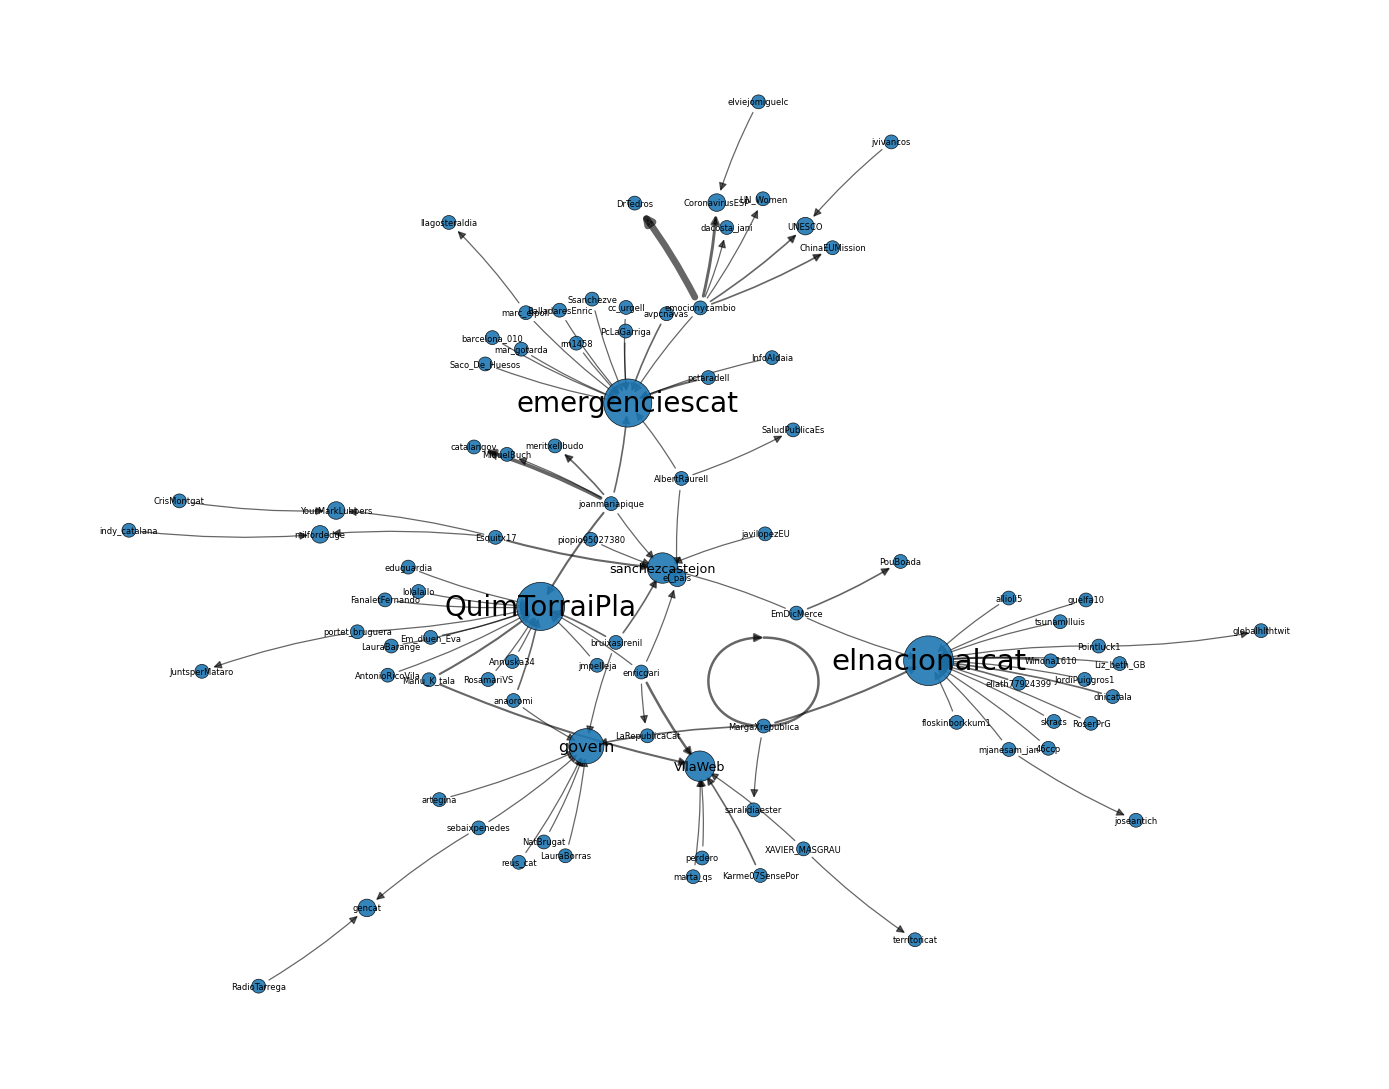

In [23]:
import matplotlib.pyplot as plt

nodes = list(lcc.nodes())
in_deg = dict(lcc.in_degree())                
node_sizes = [max(100, in_deg[n] * 80) for n in nodes]

label_sizes = {n: max(6, 2 + in_deg[n] * 1.2) for n in nodes}

edges = list(lcc.edges(data=True))
edge_widths = [max(0.6, e.get("weight", 1) * 0.3) for (_, _, e) in edges]

plt.figure(figsize=(14, 11))

nx.draw_networkx_nodes(
    lcc,
    pos,
    nodelist=nodes,
    node_size=node_sizes,
    linewidths=0.5,
    edgecolors="black",
    alpha=0.9,
)

nx.draw_networkx_edges(
    lcc,
    pos,
    edgelist=[(u, v) for (u, v, _) in edges],
    width=edge_widths,
    arrows=True,
    arrowstyle="-|>",
    arrowsize=12,
    connectionstyle="arc3,rad=0.05",
    alpha=0.6,
)


for n, (x, y) in pos.items():
    plt.text(
        x, y, s=str(n),
        fontsize=label_sizes[n],
        ha="center", va="center",
    )


plt.axis("off")
plt.tight_layout()
plt.savefig("mentions-largest-cc.png", dpi=300)
plt.show()

<font size="+1" color="red">

Replace this cell with a basic analysis of the network structure, using `networkx` functions (see [Algorithms](https://networkx.org/documentation/stable/reference/algorithms/index.html) and [Graph Functions](https://networkx.org/documentation/stable/reference/functions.html#graph)).

* What is the diameter of the largest connected component, disregarding edge direction?
* What is the size of the largest connected component, both as a number of nodes and as a percentage of the nodes in the graph?
* What is the size of the second largest connected component?

</font>

In [24]:
comps = list(nx.weakly_connected_components(g))


largest = max(comps, key=len)
second = sorted(comps, key=len, reverse=True)[1] if len(comps) > 1 else set()

diam = nx.diameter(g.subgraph(largest).to_undirected())


print("Diameter:", diam)
print("Largest component size:", len(largest))
print("Second largest component size:", len(second))
print("Largest component % of total:", len(largest)/g.number_of_nodes()*100)


Diameter: 10
Largest component size: 90
Second largest component size: 17
Largest component % of total: 25.210084033613445


<font size="+1" color="red">Replace this cell with a brief commentary on what you see in this graph, regarding its structure.</font>


The graph shows a few small groups of users that are connected to each other, but not many links between the groups. Most users only mention a few others, and there aren’t many strong connections across the whole network. The biggest group has a few main accounts in the center that get mentioned more, and the rest are smaller and less connected. Overall, it looks like people talk mostly inside their own circles.

<font size="+1" color="red">
Go back to the code above:

1. Remove the `seed` parameter in the call to `spring_layout()`, re-run the code to calculate `pos`, and visualize the network again.
2. Look at the resulting layout. Do this a few times. 

Comment briefly on what you notice. What does the `seed` parameter do? 
</font>

When I remove the seed parameter and run the layout again, the graph looks a bit different each time. The nodes move around, but the overall structure stays the same. The seed parameter just makes the layout randomizer start in the same way every time, so if you use it, the graph always looks identical. Without it, the layout changes a little each time you run it.


## 2.3. Examine degree distributions


Analyze the in- and out-degree distributions of nodes in the **largest connected component**:

* Plot both distributions.
* Plot a **scatterplot** of the in and out degree of nodes.

*Important: Make sure the plots are readable! Include x- and y-axis labels, a legend, etc.*

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to show the in- and out-degree distributions of nodes.</font>

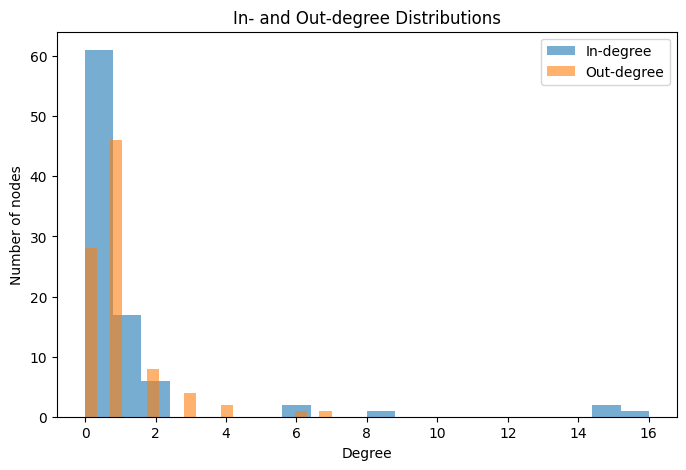

In [25]:
in_degrees = [d for n, d in lcc.in_degree()]
out_degrees = [d for n, d in lcc.out_degree()]

plt.figure(figsize=(8,5))
plt.hist(in_degrees, bins=20, alpha=0.6, label="In-degree")
plt.hist(out_degrees, bins=20, alpha=0.6, label="Out-degree")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.legend()
plt.title("In- and Out-degree Distributions")
plt.show()


<font size="+1" color="red">Replace this cell by a brief commentary, in your own words, about these degree distributions.</font>

In [ ]:
Most nodes have a low in-degree and out-degree, meaning they only mention a few others or get mentioned a few times. A small number of nodes have much higher degrees, showing that a few users are much more active or popular in the network.

<font size="+1" color="red">Replace this cell with code to generate a scatterplot of the in- and out-degrees of nodes in the LLC.</font>

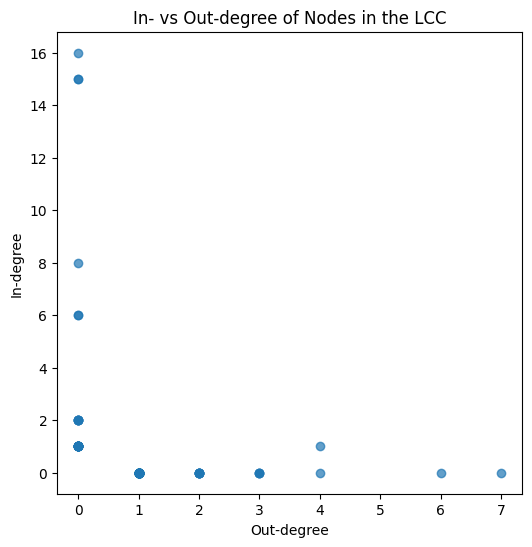

In [26]:
plt.figure(figsize=(6,6))
plt.scatter(out_degrees, in_degrees, alpha=0.7)
plt.xlabel("Out-degree")
plt.ylabel("In-degree")
plt.title("In- vs Out-degree of Nodes in the LCC")
plt.show()


<font size="+1" color="red">Replace this cell by a brief commentary, in your own words, about what you see on the scatterplot. What does it tell you about the largest strongly connected component of the graph?</font>

The scatterplot shows the same pattern as before — most users have low in- and out-degrees, while only a few have high values. This means that most people interact with just a few others, and only a small number of users are very active or popular.

# 3. Create the undirected co-mention network


The **undirected co-mention network** connects two accounts if they are both mentioned in the same tweet. The weight of the edge is the number of tweets in which the accounts are co-mentioned.

Suppose the mentions in a Tweet are in the array ``mentions``, one way to iterate through all pairs of co-mentioned is like this:

```python
    for mention1 in mentions:
        for mention2 in mentions:
            ...
```

Read the original input file again to create a dictionary `co_mentions_counter` in which keys are tuples (user1, user2) in which user1 lexicographically precedes user2 (user1 < user2), and values are the number of times user1 and user2 have appeared together in a tweet.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to create the `co_mentions_counter`.</font>


In [45]:
co_mentions_counter = {}

with gzip.open(COMPRESSED_INPUT_FILENAME, "rt", encoding="utf-8") as f:
    for line in f:
        t = json.loads(line)
        text = (
            t.get("full_text")
        )
        mentions = list(set(m.lower() for m in extract_mentions(text)))
    
        for i in range(len(mentions)):
            for j in range(i + 1, len(mentions)):
                a, b = mentions[i], mentions[j]
                if a > b:
                    a, b = b, a      # always store in alphabetical order
                co_mentions_counter[(a, b)] = co_mentions_counter.get((a, b), 0) + 1

Print the number of times the accounts `educaciocat` and `elnacionalcat` have been mentioned together. It should be 8.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>


In [46]:
# Leave this code as-is

print(co_mentions_counter[('educaciocat', 'elnacionalcat')])

4


<font size="+1" color="red">Replace this cell with your code to print all pairs of accounts that have been co-mentioned 20 times or more.</font>

Now create a file named `OUTPUT_CO_MENTIONS_FILENAME` containing co-mentions in tab-separated columns `Source, Target, Weight`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to create the co-mentions file.</font>

# 4. Visualize the undirected co-mention network 

Read the co-mentions file and create a `Graph` in which nodes are accounts and the links between them are weighted by the number of co-mentions.

Find the nodes that have a **degree larger or equal to 17**, and then create a `subgraph` with those nodes and the edges between them.

Visualize the network using a `spring_layout` that uses the `weight` edge property. A few notes:

* You can take inspiration from the layout provided when we visualized the directed mentions network earlier in this practice. But try different versions — play around with the layout properties like `k`, the number of `iterations`, or the `gravity` (if using the 'energy' method).
* Try using the 'force' method of `spring_layout`, or a completely different layout if you'd like: check the NetworkX [Drawing](https://networkx.org/documentation/stable/reference/drawing.html) documentation for options.
* Keep in mind this network is larger, so it may take more time to visualize it. Usually the most time-consuming part is calculating the layout coordinates `pos`. Some layouts are faster than others.

Style the network as you wish, what matters in the end is that your visualization is readable and the layout and styling is meaningful.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to draw the network as just described.</font>

<font size="+1" color="red">Replace this cell by a brief commentary, in your own words, of what you see in this graph. Which kinds of connected components does it have? Are connected components sparse or dense? Is there any specially dense sub-graph within the largest connected component, what is it? Include any aspects that you find relevant.</font>

# DELIVER (individually)

Deliver a zip file containing:

* Your code as a Python notebook (a `.ipynb` file).
   * Remove all unnecessary elements
   * Add comments when needed
* Any png files that you inserted in the notebook

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, text, and figures were produced by myself.</font>